In [17]:
import matplotlib.pyplot as plt
from matplotlib import style
style.use('plotting.mplstyle')
import numpy as np
import json

import sys
sys.path.append('./../code/emceeCode')
from posterior_helper_functions import *

Calculate effective samples for `betaSpikePlusTruncatedMixture

In [5]:
# Load sampleDict
sampleDict = np.load("../code/input/sampleDict_FAR_1_in_1_yr.pickle", allow_pickle=True)

# Get rid of non BBH events
non_BBHs = ['GW170817','S190425z','S190426c','S190814bv','S190917u','S200105ae','S200115j']
for event in non_BBHs:
    sampleDict.pop(event)

In [6]:
# Load hyperparameter samples
with open('../data/component_spin_betaSpikePlusTruncatedMixture.json', 'r') as f:
    data = json.load(f)

In [7]:
# dict in which to store the effective samples
Neff_dict = {}

In [11]:
# total number of hyperparameters for betaSpikePlusTruncatedMixture model
nHyperParams = len(data['mu_chi']['processed'])

# cycle through events
for event in sampleDict: 
    
    print('Calculating Neffs for', event)
    
    # Fetch samples
    chi1_samples = sampleDict[event]['a1']
    chi2_samples =  sampleDict[event]['a2']
    cost1_samples = sampleDict[event]['cost1']
    cost2_samples = sampleDict[event]['cost2']
    
    # Set up data structures in which to store Neff info
    Neffs_total = np.zeros(nHyperParams)
    Neffs_justSpike = np.zeros(nHyperParams)
    Neffs_justBulk = np.zeros(nHyperParams)

    for i in np.arange(nHyperParams):

        # Unpack parameter
        mu_chi = data['mu_chi']['processed'][i]
        sigma_chi = data['sigma_chi']['processed'][i]
        MF_cost = data['MF_cost']['processed'][i]
        sigma_cost = data['sigma_cost']['processed'][i]
        frac_in_spike = data['frac_in_spike']['processed'][i]
        sigma_spike = data['sigma_spike']['processed'][i]
        cost_min = data['cost_min']['processed'][i]
        
        a, b = mu_sigma2_to_a_b(mu_chi, sigma_chi**2.)

        # Evaluate model at the locations of our samples
        beta_chi1 = betaDistribution(chi1_samples, a, b)
        spike_chi1 = calculate_Gaussian_1D(chi1_samples, 0, sigma_spike, 0., 1.)
        p_chi1 = frac_in_spike*spike_chi1 + (1-frac_in_spike)*beta_chi1

        beta_chi2 = betaDistribution(chi2_samples, a, b)
        spike_chi2 = calculate_Gaussian_1D(chi2_samples, 0, sigma_spike, 0., 1.)
        p_chi2 = frac_in_spike*spike_chi2 + (1-frac_in_spike)*beta_chi2

        p_cost1 = calculate_Gaussian_Mixture_1D(cost1_samples, 1, sigma_cost, MF_cost, cost_min, 1.)
        p_cost2 = calculate_Gaussian_Mixture_1D(cost2_samples, 1, sigma_cost, MF_cost, cost_min, 1.)

        # Calculate effective number of samples for different parts of the distribution
        det_weights_total = p_chi1*p_chi1*p_cost1*p_cost2
        det_weights_spike = spike_chi1*spike_chi2*p_cost1*p_cost2
        det_weights_bulk = beta_chi1*beta_chi2*p_cost1*p_cost2
        
        # add to arrays
        Neffs_total[i] = np.sum(det_weights_total)**2/np.sum(det_weights_total**2)
        Neffs_justSpike[i] = np.sum(det_weights_spike)**2/np.sum(det_weights_spike**2)
        Neffs_justBulk[i] = np.sum(det_weights_bulk)**2/np.sum(det_weights_bulk**2)
        
    Neff_dict[event] = {
        'total':Neffs_total, 
        'spike':Neffs_justSpike, 
        'bulk':Neffs_justBulk
    }

Calculating Neffs for GW150914
Calculating Neffs for GW151012
Calculating Neffs for GW151226
Calculating Neffs for GW170104
Calculating Neffs for GW170608
Calculating Neffs for GW170729
Calculating Neffs for GW170809
Calculating Neffs for GW170814
Calculating Neffs for GW170818
Calculating Neffs for GW170823
Calculating Neffs for S190408an
Calculating Neffs for S190412m
Calculating Neffs for S190413ac
Calculating Neffs for S190413i
Calculating Neffs for S190421ar
Calculating Neffs for S190503bf
Calculating Neffs for S190512at
Calculating Neffs for S190513bm
Calculating Neffs for S190517h
Calculating Neffs for S190519bj
Calculating Neffs for S190521g
Calculating Neffs for S190521r
Calculating Neffs for S190527w
Calculating Neffs for S190602aq
Calculating Neffs for S190620e
Calculating Neffs for S190630ag
Calculating Neffs for S190701ah
Calculating Neffs for S190706ai
Calculating Neffs for S190707q
Calculating Neffs for S190708ap
Calculating Neffs for S190719an
Calculating Neffs for S190

In [12]:
# save because these calculations take a while
np.save('figure_08_Neff_dict.npy', Neff_dict, allow_pickle=True)

In [34]:
# load in results 3x for the 3 different cases we care about
# (will get rid of events from Neff_dict_no_def_spinning and Neff_dict_no_likely_spinning)
Neff_dict_all = np.load('figure_08_Neff_dict.npy', allow_pickle=True).reshape(1)[0]
Neff_dict_no_def_spinning = np.load('figure_08_Neff_dict.npy', allow_pickle=True).reshape(1)[0]
Neff_dict_no_likely_spinning = np.load('figure_08_Neff_dict.npy', allow_pickle=True).reshape(1)[0]

# get mins across all events
min_Neffs_total = np.min([Neff_dict_all[event]['total'] for event in Neff_dict_all], axis=0)
min_Neffs_bulk = np.min([Neff_dict_all[event]['bulk'] for event in Neff_dict_all], axis=0)
min_Neffs_spike = np.min([Neff_dict_all[event]['spike'] for event in Neff_dict_all], axis=0)

# get rid of "definitely spinning" events 
Neff_dict_no_def_spinning.pop('S190517h')
Neff_dict_no_def_spinning.pop('S190412m')
Neff_dict_no_def_spinning.pop('GW151226')
Neff_dict_no_def_spinning.pop('S191204r')
min_Neffs_spike_no_def_spinning = np.min([Neff_dict_no_def_spinning[event]['spike'] for event in Neff_dict_no_def_spinning], axis=0)

# get rid of "likely spinning" events
for event in Neff_dict_all: 
    a1_samps = sampleDict[event]['a1']
    a2_samps = sampleDict[event]['a2']
    if len(a1_samps[(a1_samps<=0.1)*(a2_samps<=0.1)]) < len(a1_samps)/200.: 
        print(event)
        Neff_dict_no_likely_spinning.pop(event)
min_Neffs_spike_no_likely_spinning = np.min([Neff_dict_no_likely_spinning[event]['spike'] for event in Neff_dict_no_likely_spinning], axis=0)

GW151226
GW170729
S190412m
S190517h
S190519bj
S190521g
S190620e
S190706ai
S190719an
S190720a
S190728q
S190805bq
S191103a
S191109d
S191127p
S191204r
S191216ap
S200129m


Make figure

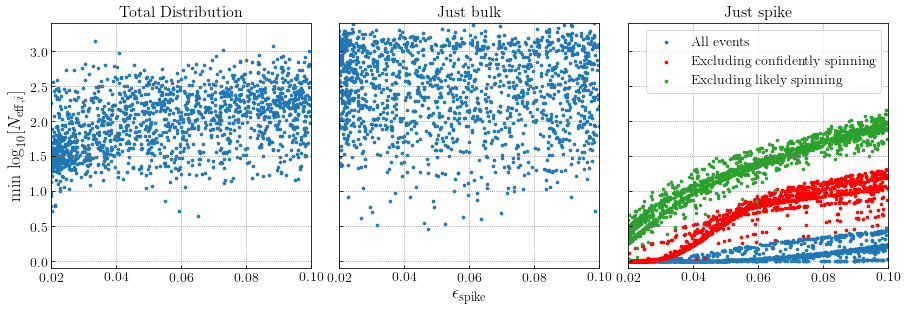

In [35]:
epsilon_spikes = data['sigma_spike']['processed']

titles = [r'Total Distribution', r'Just bulk', r'Just spike']

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 4.5), sharey=True, sharex=True)

# for total and bulk 
for i, ax, min_Neffs, title in zip(range(3), axes, [min_Neffs_total, min_Neffs_bulk, min_Neffs_spike],titles): 
    
    ax.set_rasterization_zorder(2)
    
    if i!=2:
        ax.scatter(epsilon_spikes, np.log10(min_Neffs), s=7, zorder=1)
    
    ax.set_title(title, fontsize=16)
    ax.set_xlim(0.02, 0.1)
    ax.set_ylim(-0.1, 3.4)

# for spike, each of the 3 cases     
axes[-1].scatter(epsilon_spikes, np.log10(min_Neffs_spike), s=7, zorder=1, label='All events')
axes[-1].scatter(epsilon_spikes, np.log10(min_Neffs_spike_no_def_spinning), s=7, zorder=1, color='red', label='Excluding confidently spinning')
axes[-1].scatter(epsilon_spikes, np.log10(min_Neffs_spike_no_likely_spinning), s=7, zorder=1, color='C2', label='Excluding likely spinning')

axes[1].set_xlabel(r'$\epsilon_\mathrm{spike}$')
axes[0].set_ylabel(r'min $\log_{10}[N_{\mathrm{eff},i}]$')

# legend
axes[-1].legend(loc='upper right', fontsize=14, frameon=True)

plt.subplots_adjust(wspace=0.11)
plt.savefig('figure_08.pdf', bbox_inches='tight', dpi=200)
plt.show()